# Exam: April 14th, 2025

**UE Computational Statistics** - Aix-Marseille Université / Faculté des Sciences

## Duration: 2 hours

**Instructions:**

- You are allowed to use **any documentation**, including internet, and **generative AI** (such as ChatGPT, Copilot, etc.) but not any other person.
- Please do **not add nor remove cells** in the notebook. Do **not remove comments** in the cells. Write your answers only in cells where `ANSWER TO QUESTION X.Y` is written.
- You can answer **in English or in French**.
- If you are stuck on a question because of a bug, **please ask the examiner for help**. You may lose a few points for that, but at least you will get some points for the rest of the exam.


<span style="color: green;">**FILL OUT THE FORM BELOW ABOUT YOUR IDENTITY:**</span> (do not remove this line)

First Name (Prénom): Antoine

Last Name (Nom): Legendre

Student ID (Numéro étudiant): l21204767

In [126]:
import numpy as np
import scipy
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jax.numpy as jnp
from jax import grad, hessian, jit
sns.set_style("whitegrid")

## Exercise 1: Monte Carlo methods (4 points)

We would like to approximate $\Gamma(a)$ for various values of $a>0$, where $\Gamma$ is the gamma function defined by:
$$
\Gamma(a) = \int_0^\infty x^{a-1} e^{-x} dx.
$$ 

**1.1.** Write a function `gamma(a, n)` that uses the Monte Carlo method to approximate $\Gamma(a)$ using $n$ random draws from the uniform distribution on $[0, 1]$ to compute $n$ draws from the Exponential distribution with rate $\lambda=1$. The function should return the approximation of $\Gamma(a)$ and the standard error of the approximation. 

**1.2.** Use the previous function to compute $\Gamma(1.5)$ and $\Gamma(3.5)$ with $n=10^6$ and compare the results with the values given by `scipy.special.gamma`.

**1.3.** Can you explain, intuitively, why the standard error of the approximation is larger for $\Gamma(3.5)$ than for $\Gamma(1.5)$?

In [127]:
#### ANSWER TO QUESTION 1.1 (do not remove this comment)

def gamma(a, n):
    """
    Compute the gamma function using a Monte Carlo method.
    
    Parameters:
    a (float): The parameter of the gamma function.
    n (int): The number of times to apply the recurrence relation.
    
    Returns:
    float, float: Approximation of the value of the gamma function at a, and its standard error.
    """

    # Génère n tirages uniformes sur [0, 1]
    u = np.random.uniform(0, 1, n)
    
    # Transforme les tirages uniformes en tirages exponentiels (λ = 1)
    x = -np.log(1 - u)  # Fonction inverse de la CDF exponentielle
    
    # Calcule les termes x^(a-1) pour l'estimation de Gamma(a)
    y = x ** (a - 1)
    
    # Approximation de Gamma(a) comme moyenne des y
    approximation = float(np.mean(y))
    
    # Calcul de l'erreur standard
    SE = float(np.std(y) / np.sqrt(n))
    
    return approximation, SE

In [128]:
#### ANSWER TO QUESTION 1.2 (do not remove this comment)
# Calculs avec n = 10^6
n = 10**6

print("MC approx, SE: ", gamma(1.5, n))
print("Exact value:", scipy.special.gamma(1.5), "\n")
print("MC approx, SE: ", gamma(3.5, n))
print("Exact value:", scipy.special.gamma(3.5), "\n")

MC approx, SE:  (0.884998317070795, 0.00046281413000917517)
Exact value: 0.8862269254527579 

MC approx, SE:  (3.317846575008704, 0.01038696297532959)
Exact value: 3.323350970447843 



<span style="color: green;">**ANSWER TO QUESTION 1.3:**</span> (do not remove this line)

La différence d'erreur standard entre $\Gamma(3.5)$ et $\Gamma(1.5)$ s'explique par la nature de l'intégrande $x^{a-1}e^{-x}$ dans la fonction gamma :

 
Pour $a = 3.5$ ($x^{2.5}$), les valeurs de $x$ élevées contribuent beaucoup plus à l'intégrale que pour $a = 1.5$ ($x^{0.5}$). Or, ces valeurs élevées sont rares (car $e^{-x}$ décroît vite), mais extrêmement variables.  

Exemple :  
   - Un tirage $x \approx 10$ donne $x^{0.5} \approx 3.16$ (pour $\Gamma(1.5)$)  
   - Le même tirage donne $x^{2.5} \approx 316$ (pour $\Gamma(3.5)$)  
   → Une petite variation de $x$ autour de 10 induit une variation bien plus grande pour $a=3.5$.

## Exercise 2: Importance sampling (4 points)

Consider a Bayesian model to explain the dataset composed of only one observation $x$ (For example, $x=2.5$):
$$
X \sim \mathscr{N}(\theta, 1), \quad \theta \sim \mathscr{C}(0, 1).
$$
where $\mathscr{C}(0, 1)$ is the Cauchy distribution with location $0$ and scale $1$. Its PDF is given by
$$
\pi(\theta) = \frac{1}{\pi(1+\theta^2)}.
$$

**2.1.** Show that 
$$
\mathbb{E}(\theta | X=x) = \int_{-\infty}^{+\infty} \theta \frac{1}{1+\theta^2} e^{-\frac{(x-\theta)^2}{2}} d\theta \Big/ \int_{-\infty}^{+\infty} \frac{1}{1+\theta^2} e^{-\frac{(x-\theta)^2}{2}} d\theta.
$$

**2.2.** Using two Monte Carlo approximations, show that the posterior mean $\mathbb{E}(\theta | X=x)$ can be approximated by:
$$
\widehat{\theta}_n^\text{MC} = \sum_{i=1}^n \frac{\theta_i}{(1+\theta_i^2)} \Big/ \sum_{i=1}^n \frac{1}{(1+\theta_i^2)}.
$$
where $\theta_i \sim \mathscr{N}(x, 1)$. Why is this approximation valid?

**2.3** Write a function `MC_posterior_mean(x, n)` that uses the previous approximation to compute $\mathbb{E}(\theta | X=x)$. Run it for $x=2.5$ and $n=10^6$ and print the results.

**2.4.** Now, if we sample $\theta_i$'s from the Cauchy distribution $\mathscr{C}(0, 1)$, explain why we can use the following approximation:
$$
\widehat{\theta}_n^\text{IS} = \sum_{i=1}^n \theta_i \exp\big[-(x-\theta_i)^2/2\big] \Big/ \sum_{i=1}^n \exp\big[-(x-\theta_i)^2/2\big].
$$

**2.5** Implement the function `IS_posterior_mean(x, n)` that uses the previous approximation to compute $\mathbb{E}(\theta | X=x)$. Run it for $x=2.5$ and $n=10^6$ and print the results.


<span style="color: green;">**ANSWER TO QUESTION 2.1:**</span> (do not remove this line)

On souhaite exprimer l'espérance conditionnelle $\mathbb{E}(\theta \mid X = x)$ dans un cadre bayésien avec le modèle suivant :

- $X \sim \mathcal{N}(\theta, 1)$, donc la vraisemblance est :  
  $$
  p(x \mid \theta) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x - \theta)^2}{2}},
  $$
- $\theta \sim \mathscr{C}(0,1)$, donc la densité a priori est :  
  $$
  \pi(\theta) = \frac{1}{\pi(1 + \theta^2)}.
  $$

L’espérance a posteriori de $\theta$ étant donné $x$ s’écrit :
$$
\mathbb{E}(\theta \mid X = x) = \int_{-\infty}^{+\infty} \theta \cdot p(\theta \mid x) \, d\theta,
$$
où $p(\theta \mid x)$ est la densité a posteriori.

D’après la formule de Bayes :
$$
p(\theta \mid x) = \frac{p(x \mid \theta)\pi(\theta)}{p(x)},
$$
où $p(x) = \int_{-\infty}^{+\infty} p(x \mid \theta)\pi(\theta)\,d\theta$ est la constante de normalisation.

Donc :
$$
\mathbb{E}(\theta \mid X = x) = \frac{\int_{-\infty}^{+\infty} \theta \cdot p(x \mid \theta)\pi(\theta) \, d\theta}{\int_{-\infty}^{+\infty} p(x \mid \theta)\pi(\theta) \, d\theta}.
$$

On remplace :
- $p(x \mid \theta) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x - \theta)^2}{2}}$,
- $\pi(\theta) = \frac{1}{\pi(1 + \theta^2)}$.

Le facteur $\frac{1}{\sqrt{2\pi}}$ est constant et présent à la fois au numérateur et au dénominateur ; il s’annule donc.

Ainsi :
$$
\mathbb{E}(\theta \mid X = x) = \frac{\int_{-\infty}^{+\infty} \theta \cdot \frac{1}{1 + \theta^2} e^{-\frac{(x - \theta)^2}{2}} \, d\theta}{\int_{-\infty}^{+\infty} \frac{1}{1 + \theta^2} e^{-\frac{(x - \theta)^2}{2}} \, d\theta}.
$$

On a bien montré que :
$$
\mathbb{E}(\theta \mid X = x) = \int_{-\infty}^{+\infty} \theta \frac{1}{1+\theta^2} e^{-\frac{(x-\theta)^2}{2}} d\theta \Big/ \int_{-\infty}^{+\infty} \frac{1}{1+\theta^2} e^{-\frac{(x-\theta)^2}{2}} d\theta,
$$
ce qui correspond à l’expression demandée.

<span style="color: green;">**ANSWER TO QUESTION 2.2:**</span> (do not remove this line)

On introduit une densité de proposition $q(\theta)$, et on réécrit les deux intégrales en termes d’une espérance sous $q$ :

Soit $q(\theta) = \mathcal{N}(x, 1)$. On va tirer des échantillons $\theta_i \sim q$ pour approximer l'intégrale.

Remarquons que :

- la densité cible est $f(\theta) = \frac{1}{1 + \theta^2} e^{-\frac{(x - \theta)^2}{2}}$,
- la densité de proposition est $q(\theta) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(\theta - x)^2}{2}}$.

Comme $f(\theta)$ contient déjà $e^{-\frac{(x - \theta)^2}{2}}$, et $q(\theta)$ aussi, on remarque que $q(\theta) \propto e^{-\frac{(x - \theta)^2}{2}}$ est proportionnelle à la partie gaussienne de la densité cible.

On peut donc écrire les deux intégrales comme des espérances sous $q$ :

- Numérateur :
  $$
  \int \theta \cdot \frac{f(\theta)}{q(\theta)} q(\theta) d\theta \propto \int \theta \cdot \frac{1}{1+\theta^2} q(\theta) d\theta,
  $$
  puisque $\frac{f(\theta)}{q(\theta)} \propto \frac{1}{1+\theta^2}$.

- Dénominateur :
  $$
  \int \frac{f(\theta)}{q(\theta)} q(\theta) d\theta \propto \int \frac{1}{1+\theta^2} q(\theta) d\theta.
  $$

Ainsi, on approxime :
$$
\mathbb{E}(\theta \mid X = x) \approx \frac{\frac{1}{n} \sum_{i=1}^n \theta_i \cdot \frac{1}{1 + \theta_i^2}}{\frac{1}{n} \sum_{i=1}^n \frac{1}{1 + \theta_i^2}} = \sum_{i=1}^n \frac{\theta_i}{1 + \theta_i^2} \Big/ \sum_{i=1}^n \frac{1}{1 + \theta_i^2}.
$$

où $\theta_i \sim \mathcal{N}(x, 1)$ sont des échantillons indépendants.

Cette approximation est valide car :
- La densité de proposition $q(θ)$ couvre les principales régions de la densité cible (en particulier les queues), 
- La densité de proposition $q(\theta) = \mathcal{N}(x, 1)$ est proche de la densité cible (la gaussienne dans $f(\theta)$ est centrée en $x$),
- Le rapport $\frac{f(\theta)}{q(\theta)}$ est alors simplement proportionnel à $\frac{1}{1 + \theta^2}$, ce qui est facile à manipuler,
- La méthode de Monte Carlo par importance donne une estimation consistante dès lors que les queues de $q$ couvrent celles de la distribution cible (ici c’est bien le cas car la queue de la Cauchy est lourde, mais $q$ est centrée en $x$),
- Le rapport de deux moyennes pondérées donne une approximation de l’espérance a posteriori.

On obtient donc l’approximation :
$$
\widehat{\theta}_n^{\text{MC}} = \sum_{i=1}^n \frac{\theta_i}{1 + \theta_i^2} \Big/ \sum_{i=1}^n \frac{1}{1 + \theta_i^2}, \quad \text{où } \theta_i \sim \mathcal{N}(x, 1),
$$
qui est une approximation Monte Carlo par importance sampling de $\mathbb{E}(\theta \mid X = x)$.

In [129]:
#### ANSWER TO QUESTION 2.3 (do not remove this comment)

def MC_posterior_mean(x, n):
    """
    Compute the posterior mean using a Monte Carlo method.
    
    Parameters:
    x (float): The observed data.
    n (int): The number of samples to draw from the proposal distribution.
    
    Returns:
    float: Approximation of the posterior mean.
    """
    # Échantillons tirés depuis la proposition q ~ N(x, 1)
    theta_samples = np.random.normal(loc=x, scale=1.0, size=n)
    
    # Poids non normalisés w_i = 1 / (1 + theta_i^2)
    weights = 1 / (1 + theta_samples**2)
    
    # Estimateur de l'espérance conditionnelle
    posterior_mean = np.sum(theta_samples * weights) / np.sum(weights)
    
    return posterior_mean

# Exécution avec x = 2.5 et n = 10^6
print("Posterior mean: ", MC_posterior_mean(2.5, 10**6))

Posterior mean:  1.7537675481857018


<span style="color: green;">**ANSWER TO QUESTION 2.4:**</span> (do not remove this line)

$$
\mathbb{E}(\theta \mid X = x) = \frac{\int \theta \cdot \pi(\theta) \cdot \mathcal{L}(x \mid \theta) \, d\theta}{\int \pi(\theta) \cdot \mathcal{L}(x \mid \theta) \, d\theta}
$$

où :
- $\pi(\theta) = \dfrac{1}{\pi(1 + \theta^2)}$ est la densité a priori de $\theta$ (Cauchy),
- $\mathcal{L}(x \mid \theta) = \dfrac{1}{\sqrt{2\pi}} e^{-\frac{(x - \theta)^2}{2}}$ est la vraisemblance.

On veut approximer ces intégrales en utilisant des échantillons $\theta_i$ tirés depuis la loi a priori $\mathscr{C}(0,1)$.

On note que dans ce cas, la densité de proposition est $q(\theta) = \pi(\theta)$ (la loi a priori), donc :

- Le numérateur devient :
  $$
  \mathbb{E}_q\left[\theta \cdot \frac{\mathcal{L}(x \mid \theta)}{q(\theta)}\right] = \mathbb{E}_\pi\left[\theta \cdot \mathcal{L}(x \mid \theta)\right]
  $$

- Le dénominateur devient :
  $$
  \mathbb{E}_\pi\left[\mathcal{L}(x \mid \theta)\right]
  $$

Car $\pi(\theta)$ s’annule avec $q(\theta)$.

On tire donc des $\theta_i \sim \mathscr{C}(0,1)$ et on approxime :

$$
\mathbb{E}(\theta \mid X = x) \approx \frac{\sum_{i=1}^n \theta_i \cdot \mathcal{L}(x \mid \theta_i)}{\sum_{i=1}^n \mathcal{L}(x \mid \theta_i)}
= \frac{\sum_{i=1}^n \theta_i \cdot \exp\left[-\frac{(x - \theta_i)^2}{2}\right]}{\sum_{i=1}^n \exp\left[-\frac{(x - \theta_i)^2}{2}\right]}.
$$

On obtient donc l’approximation :
$$
\widehat{\theta}_n^\text{IS} = \sum_{i=1}^n \theta_i \exp\left[-\frac{(x - \theta_i)^2}{2}\right] \Big/ \sum_{i=1}^n \exp\left[-\frac{(x - \theta_i)^2}{2}\right].
$$

Cette approximation est valide car :
- La densité de proposition $q(θ)$ couvre les principales régions de la densité cible (en particulier les queues), 
- Elle repose sur le fait que $\theta_i$ sont tirés de la loi a priori $\pi(\theta)$,
- Et qu’on pondère chaque échantillon par sa vraisemblance $\mathcal{L}(x \mid \theta_i)$,
- Ce qui correspond exactement à une approximation de l’espérance a posteriori par importance sampling,
- Les poids sont donc $w_i = \mathcal{L}(x \mid \theta_i) = \exp\left[-\frac{(x - \theta_i)^2}{2}\right]$ (on peut omettre la constante $\frac{1}{\sqrt{2\pi}}$ qui se simplifie dans le rapport).

In [130]:
#### ANSWER TO QUESTION 2.5 (do not remove this comment)

def IS_posterior_mean(x, n):
    """
    Compute the posterior mean using an importance sampling method.
    
    Parameters:
    x (float): The observed data.
    n (int): The number of samples to draw from the prior distribution (Cauchy).
    
    Returns:
    float: Approximation of the posterior mean.
    """
    # Tirer des échantillons de la distribution Cauchy(0, 1)
    theta_samples = np.random.standard_cauchy(size=n)
    
    # Calcul des poids (vraisemblance) : w_i = exp[-(x - theta_i)^2 / 2]
    weights = np.exp(-0.5 * (x - theta_samples)**2)
    
    # Calcul de l'espérance conditionnelle par importance sampling
    posterior_mean = np.sum(theta_samples * weights) / np.sum(weights)
    
    return posterior_mean

# Exécution avec x = 2.5 et n = 10^6
print("Posterior mean: ", IS_posterior_mean(2.5, 10**6))

Posterior mean:  1.7507608372773253


## Exercise 3: Probit model (6 points)

The statistical model of the Probit regression is as follows. First, the random dataset is:
$$
D = \begin{pmatrix} \mathbf Y & \mathbf X \end{pmatrix} =
\begin{pmatrix}
Y_1 & X_{11} & \cdots & X_{1p}\\
\vdots & \vdots & \ddots & \vdots\\
Y_n & X_{n1} & \cdots & X_{np}
\end{pmatrix} 
$$
where $Y_i \in \{0,1\}$ is the binary response variable, and $X_{ij}$ are the $j$-th covariate of the $i$-th observation. The rows of $D$ are iid, the marginal distribution of $X_i=(X_{i1},\ldots,X_{ip})$ is not specified, and the conditional distribution of $Y_i$ given $(X_{i1},\ldots,X_{ip})$ is a Bernoulli distribution with parameter $p(X_i)$:
$$
[Y_i|X_i] \sim \text{Bernoulli}\Big(p(X_i)\Big),$$
with success probability
$$
p(X_i)= \Phi\left(\beta_0+\sum_{j=1}^p\beta_j X_{ij}\right).
$$
where $\Phi$ is the cumulative distribution function of the standard normal distribution, and $\beta=(\beta_0,\ldots,\beta_p)$ is the vector of parameters to be estimated.

The (conditional) likelihood of the data $d$ is:
$$
f(\mathbf y|\beta, \mathbf x) = \prod_{i=1}^n p(x_i)^{y_i} \left(1-p(x_i)\right)^{1-y_i}.
$$

We use the same dataset as in the Lab Sessions, which is available in the file `wells.csv`. 

In [131]:
data = pd.read_csv('wells.csv')
data.head()
y = jnp.array(data['switch'])
x = jnp.array(data[['arsenic', 'assoc', 'dist', 'educ']])
x = (x - x.mean(axis=0)) / x.std(axis=0)
x1 = jnp.hstack((jnp.ones((x.shape[0], 1)), x))
x1.shape
x.shape, x1.shape, y.shape

((3020, 4), (3020, 5), (3020,))

**3.1.** Using JAX, write a function `probit_log_likelihood(beta, x, y)` that computes the log-likelihood of the Probit model. 

**3.2.** Using automatic differentiation, get functions that compute the score function and the Hessian of the log-likelihood.

**3.3.** Implement a gradient descent algorithm to compute the maximum likelihood estimate (MLE) of $\beta$. 

**3.4.** Use the gradient descent algorithm to compute the MLE of $\beta$ for the dataset `wells.csv`.

**3.5.** Compute the observed information matrix at the MLE and use it to get the standard errors of each coordinate of the MLE.

In [132]:
#### ANSWER TO QUESTION 3.1 (do not remove this comment)

from jax.scipy.stats import norm
@jit
def probit_log_likelihood(beta, x, y):
    """
    Compute the log-likelihood of the data given the model parameters.
    
    Parameters:
    beta (array): The model parameters.
    x (array): The input data.
    y (array): The observed data.
    
    Returns:
    float: The log-likelihood value.
    """
    # Calcul des probabilités p(X_i) = Φ(X_i·β)
    linear_pred = jnp.dot(x, beta)
    p = norm.cdf(linear_pred)
    
    # Calcul de la log-vraisemblance:
    # Σ [y_i * log(p_i) + (1-y_i)*log(1-p_i)]
    log_lik = jnp.sum(y * jnp.log(p) + (1 - y) * jnp.log(1 - p))
    
    return log_lik

# Test avec des paramètres nuls
ll = probit_log_likelihood(jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]), x1, y)
print("Log-likelihood: ", ll)

Log-likelihood:  -2093.3057


In [133]:
#### ANSWER TO QUESTION 3.2 (do not remove this comment)

# Fonction score (gradient)
score_function = grad(probit_log_likelihood)

# Fonction Hessienne
hessian_function = hessian(probit_log_likelihood)

# Exemple d'utilisation avec β=0
beta_test = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])

# Calcul du score
score = score_function(beta_test, x1, y)
print("Vecteur Score:\n", score)

# Calcul de la Hessienne
hess = hessian_function(beta_test, x1, y)
print("Matrice Hessienne:\n", hess)

Vecteur Score:
 [ 362.2387    438.01575   -85.556885 -280.96402   181.93246 ]
Matrice Hessienne:
 [[-1.9225912e+03  1.7070770e-04  2.0980835e-05 -1.4686584e-04
   7.5340271e-05]
 [ 1.6593933e-04 -1.9225916e+03  4.7894672e+01 -3.4233228e+02
   5.6837307e+01]
 [ 2.0980835e-05  4.7894684e+01 -1.9225909e+03  6.6527567e+00
   6.0305275e+01]
 [-1.4114380e-04 -3.4233224e+02  6.6527615e+00 -1.9225916e+03
   5.1411911e+01]
 [ 4.1961670e-05  5.6837315e+01  6.0305237e+01  5.1411922e+01
  -1.9225918e+03]]


In [134]:
#### ANSWER TO QUESTION 3.3 (do not remove this comment)

from jax import value_and_grad

def gradient_descent_probit(x, y, beta_init, learning_rate=0.0001, max_iter=1000, tol=1e-6):
    """
    Algorithme de descente de gradient pour estimer les paramètres β du modèle Probit.
    
    Paramètres:
    x (array): Matrice des variables explicatives (n x p)
    y (array): Vecteur des réponses binaires (n)
    beta_init (array): Valeur initiale des paramètres (p)
    learning_rate (float): Taux d'apprentissage
    max_iter (int): Nombre maximal d'itérations
    tol (float): Tolérance pour la convergence
    
    Retourne:
    array: Estimation des paramètres β
    """
    beta = beta_init.copy()
    
    for i in range(max_iter):
        # Calcule log-vraisemblance et gradient simultanément
        log_lik, grad = value_and_grad(probit_log_likelihood)(beta, x, y)
        
        # Mise à jour des paramètres
        beta += learning_rate * grad  # On maximise donc on ajoute le gradient
        
        # Critère de convergence
        if jnp.linalg.norm(grad) < tol:
            print(f"Convergence atteinte après {i} itérations")
            break
    
    return beta

In [135]:
#### ANSWER TO QUESTION 3.4 (do not remove this comment)

# Initialiser les paramètres beta
beta_init = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])

# Utiliser l'algorithme de descente de gradient pour calculer l'estimation MLE de beta
beta_MLE = gradient_descent_probit(x1, y, beta_init, learning_rate=0.0001, max_iter=1000, tol=1e-6)

# Afficher les résultats
print("MLE: ", beta_MLE)

MLE:  [ 0.20448942  0.30615103 -0.03934551 -0.21006721  0.106791  ]


In [136]:
#### ANSWER TO QUESTION 3.5 (do not remove this comment)

# Calculer la matrice Hessienne à l'estimation MLE (utiliser l'estimation MLE de beta)
hessian_at_MLE = hessian_function(beta_MLE, x1, y)

# Calculer l'information observée (opposée de la Hessienne)
observed_information = -hessian_at_MLE

# Afficher la matrice d'information observée
print("Observed information: \n", jnp.round(observed_information, 4), "\n")

# Calculer les erreurs standards (racine carrée des éléments diagonaux de l'inverse de la matrice d'information observée)
# Inverser la matrice d'information observée
observed_information_inv = jnp.linalg.inv(observed_information)

# Erreurs standards
SE = jnp.sqrt(jnp.diagonal(observed_information_inv))

# Afficher les erreurs standards
print("Standard errors: ", jnp.round(SE, 4), "\n")

Observed information: 
 [[1817.8043   -128.2705     23.3774      4.4962    -33.9309  ]
 [-128.2705   1541.4315    -25.1299    385.2688    -97.929794]
 [  23.3774    -25.1299   1825.1066    -22.6435    -43.7323  ]
 [   4.4962    385.2688    -22.6435   1771.679     -19.7565  ]
 [ -33.9309    -97.929794  -43.7323    -19.7565   1797.4014  ]] 

Standard errors:  [0.0235 0.0263 0.0234 0.0244 0.0236] 



## Exercise 4: a simple Gibbs sampler (6 points)

In this exercise, we want to sample $\mathbb R^2$ according to $\mathscr N_2(\mu, \Sigma)$, the 2-dimensional Gaussian distribution with mean $\mu=(0,0)$ and covariance matrix $\Sigma$:
$$
\Sigma = \begin{pmatrix}
\sigma_{11} & \sigma_{12}\\
\sigma_{21} & \sigma_{22}
\end{pmatrix} = \begin{pmatrix}
1 & 0.5\\
0.5 & 1
\end{pmatrix}.
$$

The PDF of $\mathscr N_2(\mu, \Sigma)$ is given, for all $x=(x_1, x_2)\in\mathbb R^2$, by:
$$
f(x) = \frac{1}{2\pi \sqrt{|\Sigma|}} \exp\left(-\frac{1}{2} x^T \Sigma^{-1} x\right),
$$
where
$$
\Sigma^{-1} = \begin{pmatrix}
4/3 & -2/3\\
-2/3 & 4/3
\end{pmatrix}, |\Sigma| = 3/4.
$$

Assume that $X\sim \mathscr N_2(\mu, \Sigma)$ and that we want to sample $X$ using a Gibbs sampler.

**4.1.** Compute the conditional distributions $[X_1|X_2]$ and $[X_2|X_1]$.

**4.2.** Implement a Gibbs algorithm that samples from $\mathscr N_2(\mu, \Sigma)$ using the conditional distributions computed in the previous question.

**4.3.** Run the Gibbs sampler for $n=10^5$ iterations and plot the first $1000$ draws in the plane $(X_1, X_2)$.

**4.4.** Plot the path of the first coordinate of the Gibbs sampler and the histogram of the first coordinate of the output. Compare it with the PDF of $X_1$, which is a Gaussian distribution with mean $0$ and variance $1$.

**4.5.** Use the output of the Gibbs sampler to approximate the covariance between $X_1$ and $X_2$. Is it the correct value? 




In [137]:
# Check that linear algebra is correct
Sigma = jnp.array([[1, 0.5], [0.5, 1]])
Sigma_inv = jnp.array([[4./3., -2./3.], [-2./3., 4./3.]])
# Product
Sigma_Sigma_inv = jnp.dot(Sigma, Sigma_inv)
print("Sigma * Sigma_inv: \n", jnp.round(Sigma_Sigma_inv, 4), "\n")
print("determinant(Sigma): ", jnp.round(jnp.linalg.det(Sigma), 4), "\n")

Sigma * Sigma_inv: 
 [[1. 0.]
 [0. 1.]] 

determinant(Sigma):  0.75 



<span style="color: green;">**ANSWER TO QUESTION 4.1:**</span> (do not remove this line)

Pour résoudre cette question **4.1**, on cherche à calculer les **lois conditionnelles** suivantes :

- $[X_1 \mid X_2 = x_2]$
- $[X_2 \mid X_1 = x_1]$

où $(X_1, X_2) \sim \mathscr{N}_2(\mu, \Sigma)$ avec :
$$
\mu = \begin{pmatrix} 0 \\ 0 \end{pmatrix}, \quad
\Sigma = \begin{pmatrix} 1 & 0.5 \\ 0.5 & 1 \end{pmatrix}
$$

Si 
$$
\begin{pmatrix} X_1 \\ X_2 \end{pmatrix} \sim \mathscr{N}_2\left(
\begin{pmatrix} \mu_1 \\ \mu_2 \end{pmatrix},
\begin{pmatrix} \sigma_{11} & \sigma_{12} \\ \sigma_{21} & \sigma_{22} \end{pmatrix}
\right)
$$

alors :

- La loi de $X_1 \mid X_2 = x_2$ est une loi normale univariée :
  $$
  X_1 \mid X_2 = x_2 \sim \mathscr{N}\left(\mu_1 + \frac{\sigma_{12}}{\sigma_{22}} (x_2 - \mu_2), \sigma_{11} - \frac{\sigma_{12}^2}{\sigma_{22}}\right)
  $$

- La loi de $X_2 \mid X_1 = x_1$ est :
  $$
  X_2 \mid X_1 = x_1 \sim \mathscr{N}\left(\mu_2 + \frac{\sigma_{21}}{\sigma_{11}} (x_1 - \mu_1), \sigma_{22} - \frac{\sigma_{21}^2}{\sigma_{11}}\right)
  $$

Or, on a :

- $\mu_1 = \mu_2 = 0$
- $\sigma_{11} = \sigma_{22} = 1$
- $\sigma_{12} = \sigma_{21} = 0.5$

Donc :

- $[X_1 \mid X_2 = x_2] \sim \mathscr{N}(0.5 x_2, 0.75)$  
- $[X_2 \mid X_1 = x_1] \sim \mathscr{N}(0.5 x_1, 0.75)$

In [138]:
#### ANSWER TO QUESTION 4.2 (do not remove this comment)

def gibbs_sampler(n):
    """
    Perform Gibbs sampling to generate samples from the target distribution.
    
    Parameters:
    n (int): The number of samples to generate.
    
    Returns:
    ndarray: Generated samples.
    """
    draws = np.zeros((n, 2))  # Initialiser la matrice des échantillons

    # Paramètres des conditionnelles :
    mu_cond = 0.5
    var_cond = 0.75
    std_cond = np.sqrt(var_cond)

    # Initialisation à 0
    x1, x2 = 0, 0

    for i in range(n):
        # Échantillonner x1 conditionnellement à x2
        x1 = np.random.normal(loc=mu_cond * x2, scale=std_cond)
        
        # Échantillonner x2 conditionnellement à x1
        x2 = np.random.normal(loc=mu_cond * x1, scale=std_cond)
        
        # Stocker les tirages
        draws[i, :] = [x1, x2]

    return draws

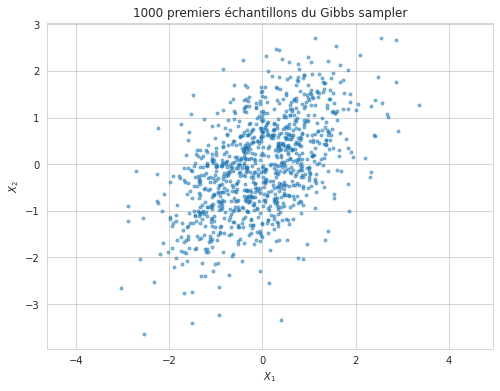

In [139]:
#### ANSWER TO QUESTION 4.3 (do not remove this comment)

# Lancer le Gibbs sampler
sample = gibbs_sampler(10**5)

# Extraire les 1000 premiers échantillons
samples_1000 = sample[:1000, :]

# Tracer les points dans le plan (X1, X2)
plt.figure(figsize=(8, 6))
plt.plot(samples_1000[:, 0], samples_1000[:, 1], 'o', alpha=0.5, markersize=3)
plt.title("1000 premiers échantillons du Gibbs sampler")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.grid(True)
plt.axis("equal")
plt.show()

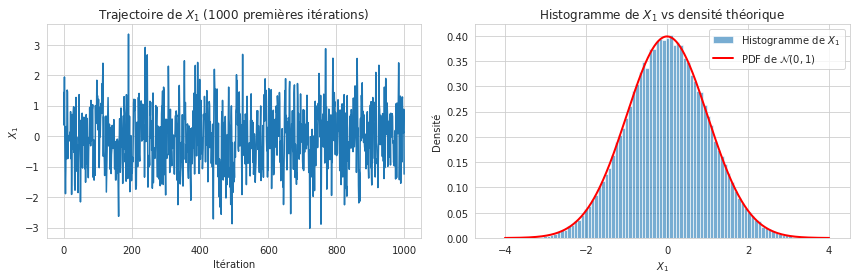

In [140]:
#### ANSWER TO QUESTION 4.4 (do not remove this comment)

# On suppose que `samples` contient déjà 10^5 échantillons générés par gibbs_sampler
X1 = sample[:, 0]

# 1. Trajectoire de X1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(X1[:1000])
plt.title("Trajectoire de $X_1$ (1000 premières itérations)")
plt.xlabel("Itération")
plt.ylabel("$X_1$")
plt.grid(True)

# 2. Histogramme + densité théorique
plt.subplot(1, 2, 2)
plt.hist(X1, bins=100, density=True, alpha=0.6, label="Histogramme de $X_1$")

# Densité théorique de N(0,1)
x_vals = np.linspace(-4, 4, 500)
plt.plot(x_vals, stats.norm.pdf(x_vals, loc=0, scale=1), 'r-', lw=2, label="PDF de $\mathcal{N}(0,1)$")

plt.title("Histogramme de $X_1$ vs densité théorique")
plt.xlabel("$X_1$")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [141]:
#### ANSWER TO QUESTION 4.5-code (do not remove this comment)

# Extraire X1 et X2 des échantillons
X1 = sample[:, 0]
X2 = sample[:, 1]

# Calculer les moyennes empiriques de X1 et X2
mean_X1 = np.mean(X1)
mean_X2 = np.mean(X2)

# Calculer la covariance empirique
cov_X1_X2 = np.mean((X1 - mean_X1) * (X2 - mean_X2))

# Afficher la covariance empirique et la covariance théorique
print("Covariance empirique entre X1 et X2 : ", cov_X1_X2)

Covariance empirique entre X1 et X2 :  0.5036081814318737


<span style="color: green;">**ANSWER TO QUESTION 4.5-comment:**</span> (do not remove this line)

On connaît la matrice de covariance théorique $\Sigma$ de la distribution $\mathscr{N}_2(\mu, \Sigma)$, qui est donnée par :

$$
\Sigma = \begin{pmatrix}
1 & 0.5 \\
0.5 & 1
\end{pmatrix},
$$

on s'attend à ce que la covariance empirique approche 0.5 ce qui est bien le cas.


## End of the exam

<span style="color: green;">Final comments</span> (do not remove this line)

Write here if you have any comments about the exam, the questions, the notebook, etc. (optional).